In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as sci_optim
import matplotlib.pyplot as plt

In [2]:
# Load data
data = np.genfromtxt('xbtusd.csv', delimiter=',')
Y = data[1:,-1] # get de-trended BITCOIN prices. Also, remove first value, since it is NaN.

In [3]:
def DAR_likelihood(phi, omega, alpha,):
    T = len(Y)
    
    sigma2 = np.zeros(T)
    e = np.zeros(T)
    logli=np.zeros(T)
    
    for t in range(1,T):
        sigma2[t]=omega + alpha*Y[t-1]**2 
        e[t]=Y[t]-(1+phi)*Y[t-1]
        logli[t]=-0.5*np.log(sigma2[t])-0.5*e[t]**2/sigma2[t]
    LogL=-np.sum(logli)
    
    return LogL

def optim(x):
    ph, ome, alp = x
    return DAR_likelihood(phi = ph, omega = ome, alpha = alp)

Par0=np.array([0.0, 0.05, 0.5]) #initial guesses
res = sci_optim.minimize(optim, Par0, method='SLSQP', bounds=((None,None),(0,None),(0,None)))
res.x

array([-0.09857414, 47.66475763,  0.18590538])

In [4]:
# array([-0.09857169, 47.66485028,  0.18590819])

# Test

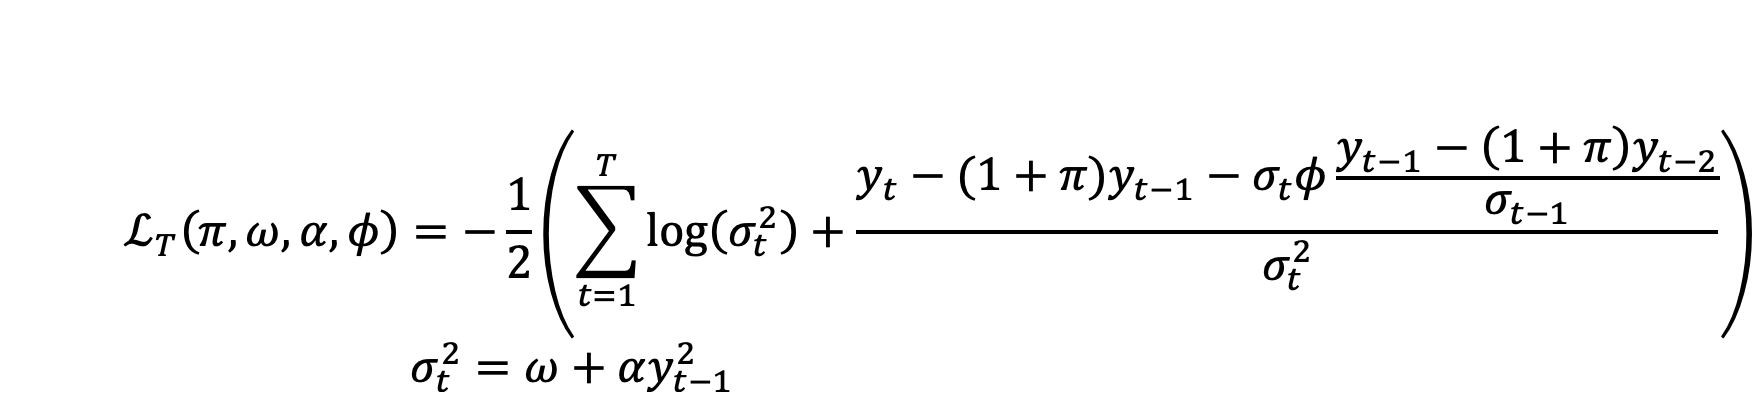

In [5]:
def DARMA_likelihood(rho, omega, alpha, phi):
    T=len(Y)
    
    sigma2=np.zeros(T)
    z = np.zeros(T)
    e=np.zeros(T)
    logli=np.zeros(T)
    
    for t in range(2,T):
        sigma2[t] = omega + alpha*Y[t-1]**2
        z[t] = phi * ( (Y[t-1] -(1+rho) * Y[t-2]) / np.sqrt(omega + alpha*Y[t-2]**2))

        e[t] = Y[t] -(1+rho) * Y[t-1] - np.sqrt(sigma2[t]) * z[t]

        logli[t]= -0.5 * np.log(sigma2[t]) -0.5 * e[t]**2 / sigma2[t]
    
    LogL=-np.sum(logli)
    
    return LogL

def optim(x):
    rh, ome, alp, ph = x
    return DARMA_likelihood(rho = rh, omega = ome, alpha = alp, phi = ph)

Par0=np.array([0.0, 0.05, 0.5, 0.0]) #initial guesses
res = sci_optim.minimize(optim, Par0, method='SLSQP', bounds = ((None,None), (0,None), (0,None), (None,None)))
rho_est, omega_est, alpha_est, phi_est = res.x


# Simulation

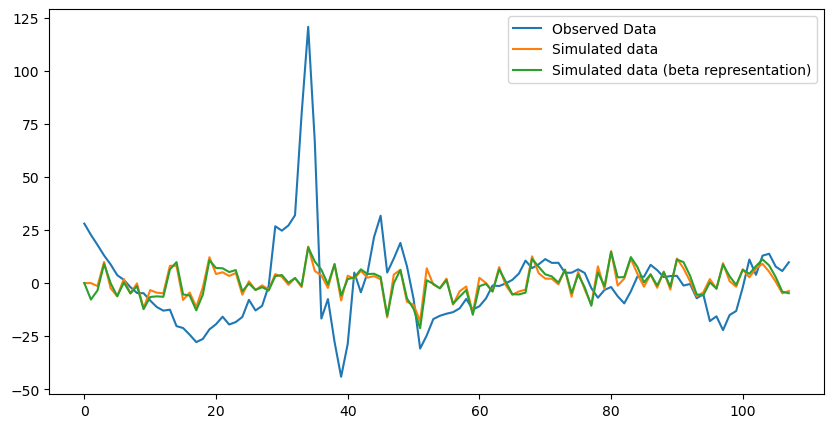

In [6]:
def DARMA_simulated(rho, omega, alpha, phi, data):
    
    T = len(data)

    np.random.seed(22525)

    Y= np.zeros(T)
    Y1 = np.zeros(T)
    Y2 = np.zeros(T)

    sigma = np.zeros(T)
    beta = np.zeros(T)
    z =  np.zeros(T)
    eta = np.random.normal(loc=0, scale=1, size=T)

    # Initialize the process
    Y[0] = np.mean(data)

    # Non-Linear Representation
    for t in range(2, T):
        sigma[t] = np.sqrt(omega + alpha * Y[t-1]**2)
        z[t-1] = phi * (Y[t-1] - (1+rho) * Y[t-2]) / np.sqrt(omega + alpha * Y[t-2]**2)
        Y1[t] = (1+rho) * Y[t-1] + sigma[t] * z[t-1] + sigma[t] * eta[t]

    # Linear (Beta) Representation
    for t in range(1, T):
        sigma[t] = np.sqrt(omega + alpha * Y[t-1]**2)
        beta[t] = sum(phi**k * eta[t - k] for k in range(t))
        Y2[t] = (1 + rho) * Y[t-1] + sigma[t] * beta[t]
    
    return Y1, Y2

Y_sim_1 = DARMA_simulated(rho_est, omega_est, alpha_est, phi_est, data = Y)[0]
Y_sim_2 = DARMA_simulated(rho_est, omega_est, alpha_est, phi_est, data = Y)[1]

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y, label='Observed Data')
plt.plot(Y_sim_1, label='Simulated data')
plt.plot(Y_sim_2, label='Simulated data (beta representation)')
plt.legend()

# Forecast

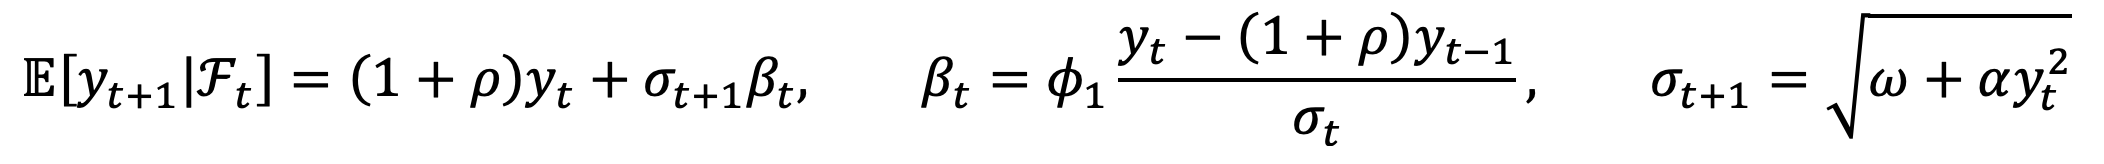

In [7]:
def DARMA_forecast(rho, omega, alpha, phi, data):
    
    t = -1 # define start index 

    y = lambda t: (data[t])
    sigma = lambda t: np.sqrt(omega + alpha * (y(t-1) ** 2))
    beta = lambda t: phi * ( y(t) - (1 + rho) * y(t-1) ) / sigma(t)

    y_pred = (1+rho) * y(t) + sigma(t+1) * beta(t)

    return y_pred

In [11]:


DARMA_forecast(rho_est, omega_est, alpha_est, phi_est, Y[0:3]),Y[0]

(13.99868791490411, array([27.98987445, 22.70122262, 17.95695986]))

In [8]:
def generate_darma_forecasts(rho, omega, alpha, phi, Y):
    start = 0
    t = 2
    y_pred_array = [] 

    n_forecasts = len(Y) - t + 1

    # Add NaN values for the first t = 2 elements
    y_pred_array.extend(np.nan for i in range(1, t + 1))

    # Loop to generate 1-step-ahead forecasts
    for _ in range(t, t + n_forecasts):
        y_pred_t = DARMA_forecast(rho, omega, alpha, phi, Y[start:t])
        y_pred_array.append(y_pred_t)

        # Increment the window for the next forecast
        start += 1
        t += 1

    # Convert to a NumPy array
    #y_pred_array = np.array(y_pred_array)

    y_pred_array = np.array(y_pred_array)

    return y_pred_array

DARMA_forecast_array = generate_darma_forecasts(rho_est, omega_est, alpha_est, phi_est, Y)

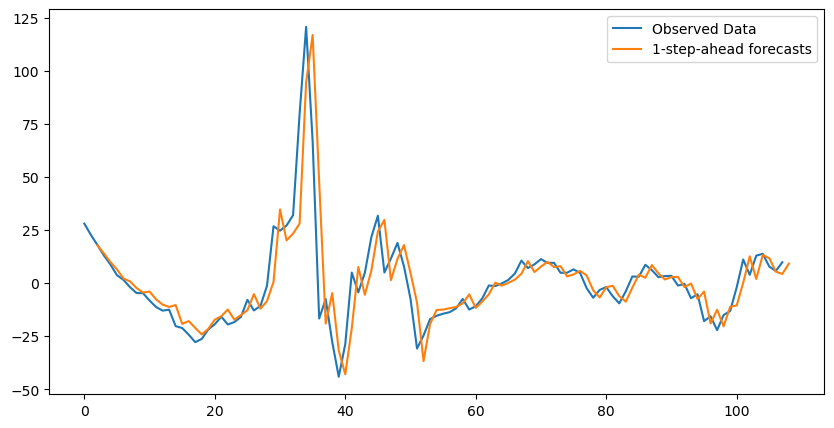

In [9]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y, label='Observed Data')
plt.plot(DARMA_forecast_array, label='1-step-ahead forecasts')
plt.legend()